# Dynamic rupture modeling of gouge patch: compare the M0 and STF

In this notebook, we compute the seismic moment and source time function obtained from the dynamic rupture modeling.
We dump the processed data into HDF5.
We evaluate the source parameters by fitting the synthetic STF in the later notebooks.

2024.02.22 Kurama Okubo

- 2025.1.30 Clean up the notebook for the master plot.
- 2025.2.3 Update for parameter study: upsampling the STF of dynamic rupture model to improve the time shift during the fitting.
- 2025.2.6 Update iterate the Tw_init to avoid the jump in the fitting residual. 

In [1]:
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import timedelta
from tqdm import tqdm
import warnings
import time
from datetime import datetime

import pickle

from scipy.optimize import minimize

from scipy.signal import freqz
from scipy import signal

import h5py
import seaborn as sns

from post_dynrup_func import *

%load_ext autoreload
%autoreload 2

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = False

plt.rcParams['axes.linewidth'] = 0.75

In [2]:
figdir = "../figure/01_M0andSTF"
if not os.path.exists(figdir):
    os.makedirs(figdir)

In [3]:
datadir = "../data/01_M0andSTF"
if not os.path.exists(datadir):
    os.makedirs(datadir)

# 1. Compute seismic moment

The seismic moment is computed as follows:

$$ M_0(t) = \mu \int_A u(\mathbf{\xi}, t) dA $$

$$ = \mu dA \sum_i^{N} u_i $$

where $dA$ is the area of grid in the simulation, which is uniform in the simulaiton.

# 2. Compute STF

The seismic moment is computed as follows:

$$ \dot{M}_0(t) = \mu \int_A \dot{u}(\mathbf{\xi}, t) dA $$

$$ = \mu dA \sum_i^{N} \dot{u}_i $$

where $dA$ is the area of grid in the simulation, which is uniform.


In [4]:
E = 96e9
nu = 0.246 # metagabbro
mu = E/(2*(1+nu))

a_patch = 4.0e-3
rupturetype = "pulse"
pdcscaling= 0.6 #0.475 #0.5 #0.55 # 0.65
bgbeta= 0.35 #0.4 #0.3 #0.5
# gammautry = 0.8

nb_x_elements = 1024 #128
nb_z_elements = 1024 #128

sig_n = 6e6

IfBinaryOutput = True

Ifmasteroutput=True
if Ifmasteroutput:
    filekey = "_master"
else:
    filekey = ""
    
read_dumpedpickle = False # false if you first run the notebook

In [5]:
# case study parameter casename
casestr = f"a={a_patch*1e3:.2f}_ruptype={rupturetype}_pdcscaling={pdcscaling:.3f}_sn={sig_n/1e6:.1f}MPa_hatfr=0.3_bgbeta={bgbeta:.2f}"

finame=f"../../preprocess_modelsetup/data/gouge_dynamicrupture_modelparam_{casestr}{filekey}.csv"

# Read model parameters
df_modelparam = pd.read_csv(finame, index_col=0)

# datadir_root = "../../../uguca/build_v42_masterfitmodel/simulations_main_casestudy"

# datadir_root = "/Volumes/4mGouge_WorkHDD/RuptureSimulation/build_hpcv15_neweventset_dt1e-8/simulations_main_casestudy_hpc"
# datadir_root = "/Volumes/4mGouge_WorkHDD/RuptureSimulation/build_hpcv52_paramstudy_v11/simulations_main_casestudy_hpc_dev"
datadir_root = "/Volumes/Okuboetal2025_masterHDD/RuptureSimulation/main_casestudy/build_hpcv62_mastercase_v3/simulations_main_casestudy_hpc_master"

casestr

'a=4.00_ruptype=pulse_pdcscaling=0.600_sn=6.0MPa_hatfr=0.3_bgbeta=0.35'

In [6]:
df_modelparam.head()

,M0_mean,Tw_mean,Mw_mean,hat_sn_patch,hat_sn_background,delsig_withmargin_try,slip_try,initialstress_fraction,delsigma_factor,fp_patch,...,GIIC_patch,GIIC_background,Sratio_nuc,Sratio_patch,Ainit_nuc,Ainit_patch,Anuc_nuc,Anuc_patch,rnuc_nuc,rnuc_patch
gougeevent_id,,,,,,,,,,,,,,,,,,,,,
4,0.592607,0.000003,-6.221489,6000000.0,2000000.0,3817368.370,2.941529e-07,0.925,0.6,0.737013,...,0.063389,0.0,0,0.144801,3.82,3.827670,0.000002,0.000002,0.783304,0.784090
9,0.046991,0.000002,-6.955323,6000000.0,2000000.0,302700.368,2.332502e-08,0.925,0.6,0.357049,...,0.001808,0.0,0,0.884659,3.82,5.060161,0.000005,0.000007,1.311379,1.509311
18,0.755830,0.000003,-6.151051,6000000.0,2000000.0,4868794.570,3.751721e-07,0.925,0.6,0.850680,...,0.092430,0.0,0,0.131041,3.82,3.825794,0.000002,0.000002,0.719315,0.719860
19,0.055755,0.000002,-6.905809,6000000.0,2000000.0,359156.898,2.767536e-08,0.925,0.6,0.363152,...,0.002218,0.0,0,0.758343,3.82,4.624378,0.000005,0.000007,1.312650,1.444255
20,0.865466,0.000003,-6.111833,6000000.0,2000000.0,5575033.400,4.295923e-07,0.925,0.6,0.927031,...,0.114155,0.0,0,0.124712,3.82,3.825041,0.000001,0.000001,0.685213,0.685665


In [7]:
# parameter study
# ifParamStudy = True # deprecated: change the file name for the parameter study
ifSaveHDF = True # dump the data to the HDF file for the following processings.
    
selectids_list = [24, 50, 52, 72, 129]


In [8]:
# # select model parameter index
# delsigma_index = {"24": 5,
#                   "50": 5,
#                   "52": 5,
#                   "72": 7,
#                   "129": 6,
#                  }

In [9]:
# # select the model index
# delsigma_factorstr = dict() 
# for ii, sid in enumerate(selectids_list):
#     delsigma_factorstr[f"{sid}"] = delsigma_factor_range[ii][delsigma_index[f"{sid}"]]
    
# delsigma_factorstr

In [10]:
delsigma_factorstr ={
    "24":0.695,
    "50":0.5,
    "52":0.46,
    "72":0.43,
    "129":0.41
}

In [11]:
delsigma_factorstr

{'24': 0.695, '50': 0.5, '52': 0.46, '72': 0.43, '129': 0.41}

In [12]:
expr_id = 87
model_ids = [24, 50, 52, 72, 129]
# model_ids = [24, 52, 129]
# model_ids = [50, 52, 72, 129]
# model_ids = [72, 129]

data_all = dict()

for model_id in model_ids:
#model_id = model_ids[0]

    df_modelparam_selected = df_modelparam[df_modelparam.index == model_id]

    # if ifParamStudy:
    simulation_name = f"fb03-{expr_id:03d}__{df_modelparam_selected.index[0]:04d}_{casestr}_{delsigma_factorstr[f'{model_id}']:.4f}"
    # else:
        # simulation_name = f"fb03-{expr_id:03d}__{df_modelparam_selected.index[0]:04d}_{casestr}"

    print(f"Process {simulation_name}")
    
    df_time = pd.read_csv(os.path.join(datadir_root,simulation_name+".time"), header=None, sep=' ', index_col=0)
    df_coord = pd.read_csv(os.path.join(datadir_root,simulation_name+".coords"), header=None, sep=' ', index_col=None)
    NT = len(df_time)

    # set coordinate
    xcoord = df_coord.loc[:,0].values
    zcoord = df_coord.loc[:,2].values

    x_length = xcoord.max()
    z_length = zcoord.max()

    dgrid = zcoord[1]-zcoord[0]
    dA = dgrid * dgrid
    print(f"Grid size: {dgrid*1e3}[mm]") 

    # read displacement
    read_parameter = "top_disp_0" # consider only the x direction.
    
    
    if IfBinaryOutput:
        D = np.fromfile(os.path.join(datadir_root,simulation_name+f"-DataFiles/{read_parameter}.out"), dtype="float32")
        df_data = pd.DataFrame(data=D.reshape((NT, -1)))
    else:
        df_data = pd.read_csv(os.path.join(datadir_root,simulation_name+f"-DataFiles/{read_parameter}.out"), header=None, sep=' ')        

    # trim the domain
    x_maxwidth=15e-3 # half width of the area to compute the moment; 15mm is large enough to encompass all the slip region
    z_maxwidth=15e-3
    M0_internal_inds_rec = np.where((np.abs(xcoord - dgrid/2 - x_length/2) <= x_maxwidth) & (np.abs(zcoord - dgrid/2 - z_length/2) <= z_maxwidth))

    # extract within the patch    
    rcoord = np.linalg.norm(np.vstack([xcoord - dgrid/2 - x_length/2, zcoord - dgrid/2 - z_length/2]), axis=0)
    M0_internal_inds_patch = np.where(rcoord <= a_patch)
    # M0_internal_inds

#     h = plt.scatter(xcoord - x_length/2, zcoord - z_length/2, c=rcoord, cmap='viridis')
#     plt.colorbar(h)

    M0_rec = np.zeros(NT)
    M0_patch = np.zeros(NT)

    for i in range(NT):
        M0_rec[i] = mu * dA * df_data.loc[i, M0_internal_inds_rec].sum()*2 # convert from top displacement to slip by multiplying 2
        M0_patch[i] = mu * dA * df_data.loc[i, M0_internal_inds_patch].sum()*2 # convert from top displacement to slip by multiplying 2

    2    # STF_patch = np.gradient(M0_patch, df_time.values.squeeze())

    # Read velocity
    read_parameter = "top_velo_0" # select the parameter to read
    
    if IfBinaryOutput:
        D = np.fromfile(os.path.join(datadir_root,simulation_name+f"-DataFiles/{read_parameter}.out"), dtype="float32")
        df_data = pd.DataFrame(data=D.reshape((NT, -1)))
    else:
        df_data = pd.read_csv(os.path.join(datadir_root,simulation_name+f"-DataFiles/{read_parameter}.out"), header=None, sep=' ')
        
    STF_rec = np.zeros(NT)
    STF_patch = np.zeros(NT)


    for i in range(NT):
        STF_rec[i] = mu * dA * df_data.loc[i, M0_internal_inds_rec].sum()*2 # convert from top half velocity to the slip velocity by multiplying 2
        STF_patch[i] = mu * dA * df_data.loc[i, M0_internal_inds_patch].sum()*2 # convert from top half velocity to the slip velocity by multiplying 2


    # store the data

    key_t = f"t_{simulation_name}"
    key_M0 = f"M0_rec_{simulation_name}"
    key_STF = f"STF_rec_{simulation_name}"
    key_STF_patch = f"STF_patch_{simulation_name}"


    data_all[key_t] = df_time[1].values
    data_all[key_M0] = M0_rec
    data_all[key_STF] = STF_rec
    data_all[key_STF_patch] = STF_patch
          
    print(f"{M0_rec[-1]:.3f}J, {M0_patch[-1]:3f}J, {(M0_rec[-1] - M0_patch[-1])/M0_rec[-1]}")
#     # Dump data
#     with open(datadir+f'/M0andSTF_all_{tau_r:.2f}.pickle', 'wb') as fo:
#         pickle.dump(data_all, fo, protocol=pickle.HIGHEST_PROTOCOL)


Process fb03-087__0024_a=4.00_ruptype=pulse_pdcscaling=0.600_sn=6.0MPa_hatfr=0.3_bgbeta=0.35_0.6950
Grid size: 0.0390625[mm]
0.064J, 0.062099J, 0.030715522369279883
Process fb03-087__0050_a=4.00_ruptype=pulse_pdcscaling=0.600_sn=6.0MPa_hatfr=0.3_bgbeta=0.35_0.5000
Grid size: 0.0390625[mm]
0.304J, 0.254109J, 0.16396343059735832
Process fb03-087__0052_a=4.00_ruptype=pulse_pdcscaling=0.600_sn=6.0MPa_hatfr=0.3_bgbeta=0.35_0.4600
Grid size: 0.0390625[mm]
0.452J, 0.352806J, 0.22030397004882665
Process fb03-087__0072_a=4.00_ruptype=pulse_pdcscaling=0.600_sn=6.0MPa_hatfr=0.3_bgbeta=0.35_0.4300
Grid size: 0.0390625[mm]
0.804J, 0.543093J, 0.32413778913975533
Process fb03-087__0129_a=4.00_ruptype=pulse_pdcscaling=0.600_sn=6.0MPa_hatfr=0.3_bgbeta=0.35_0.4100
Grid size: 0.0390625[mm]
1.142J, 0.693708J, 0.39273551062009326


In [13]:
# time step of numerical simulation

dt_dynrup = (df_time.values[1]-df_time.values[0])[0]
print(f"result dumping rate of dynamic rupture model is {dt_dynrup*1e6:.4f} μs, {1/dt_dynrup/1e6:.2f} MHz.")

result dumping rate of dynamic rupture model is 0.0098 μs, 102.27 MHz.


# Plot time history of M0

Here we plot the time history of $M_0$ to check the growth of slip.

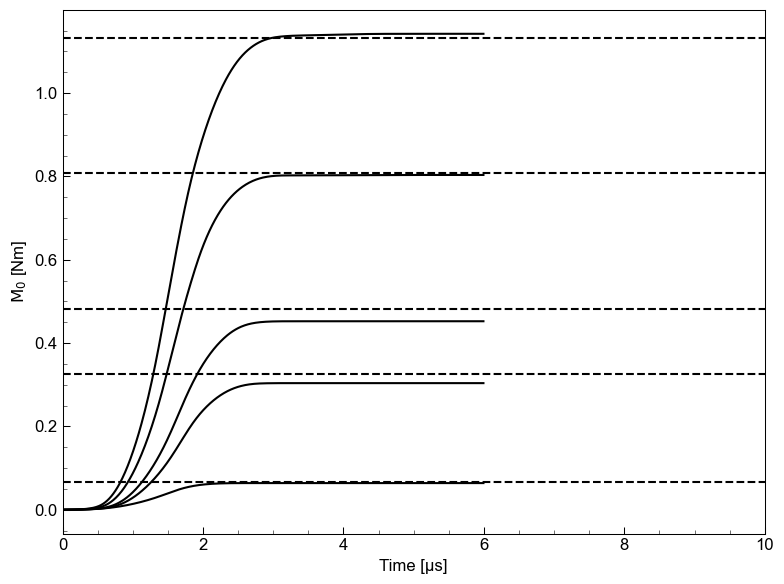

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

for model_id in model_ids:
    
    df_modelparam_selected = df_modelparam[df_modelparam.index == model_id]

    # if ifParamStudy:
    simulation_name = f"fb03-{expr_id:03d}__{df_modelparam_selected.index[0]:04d}_{casestr}_{delsigma_factorstr[f'{model_id}']:.4f}"
    # else:
        # simulation_name = f"fb03-{expr_id:03d}__{df_modelparam_selected.index[0]:04d}_{casestr}"

    key_M0 = f"M0_rec_{simulation_name}"
    
    ax.plot(df_time*1e6, data_all[key_M0], "k-")
    #     ax.plot(df_time*1e6, M0_patch, "r-", label="Dynamic rupture model patch domain")
    # ax.plot(df_time*1e6, cosine_stf, "gray", ls="--",  label=f"Cosine STF: TR={TR*1e6:.1f}μs")

    ax.axhline(df_modelparam_selected.M0_mean.values[0], ls="--", c="k")

ax.set_xlim([0, 10])
# ax.set_ylim([-0.02, 1.1])

ax.set_xlabel("Time [μs]")

ylabelstr = r"$\mathrm{{M}_0}$"
ax.set_ylabel("{} [Nm]".format(ylabelstr))

# ax.legend(loc=0)

plt.tight_layout()
plt.savefig(figdir +f"/M0_all_{casestr}{filekey}.png", dpi=300, bbox_inches="tight")

# plt.close()
# plt.clf()

# Plot source time function

We deprecated the comparison to the stacked observation of STF. We compare the modeled STF with the best-fit averaged cosine STF.

In [15]:
# load color dictionary consistent to the plot of the repeated waveforms
repeated_sensor_lcdict = "OL08" # the color dict is same for all the sensor although separately saved.
gougepatch_id = "G3"
with open(f'../../../../ComputeScaling/data/01_plot_gougeevents/lc_dict_{gougepatch_id}_{repeated_sensor_lcdict}.pkl', 'rb') as fi:
    lc_dict = pickle.load(fi)

(-0.05, 1.0)

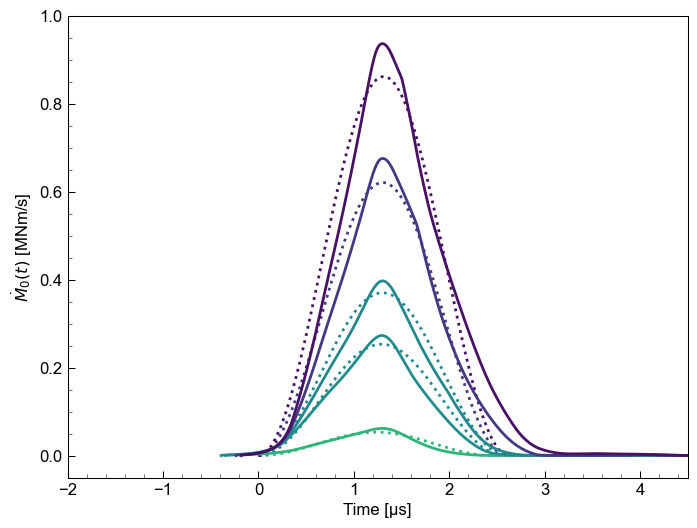

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

tvec_model = df_time.values.squeeze()

i = 0

maxloc_center = 1.3e-6

# tvec_data = np.array(fo_stack[f"param/tvec_upsampled_trimmed"])
# dt_upsampled = tvec_data[1] - tvec_data[0]

for model_id in model_ids:

    # plot observation data and synthetic STF
    datacase = f"fb03-087__{model_id:04d}"

    # plot synthetic
    df_modelparam_selected = df_modelparam[df_modelparam.index == model_id]
    M0_mean = df_modelparam_selected["M0_mean"].values[0]
    Tw_mean = df_modelparam_selected["Tw_mean"].values[0]
       
    # compute synthetic STF
    tvec_syn = np.linspace(0, Tw_mean, int(Tw_mean/dt_dynrup))
    STF_syn = stf_cosine(tvec_syn, Tw_mean, M0_mean)
    # STF_syn = stf_kupper(tvec_syn, Tw_mean, M0_mean)
    
    ax.plot((tvec_syn+0)*1e6, STF_syn/1e6, ls=":", c=lc_dict[datacase], lw=2.0) # before alignment
    
    # Plot dynamic rupture model
    df_modelparam_selected = df_modelparam[df_modelparam.index == model_id]
    
    # if ifParamStudy:
    simulation_name = f"fb03-{expr_id:03d}__{df_modelparam_selected.index[0]:04d}_{casestr}_{delsigma_factorstr[f'{model_id}']:.4f}"
    # else:
        # simulation_name = f"fb03-{expr_id:03d}__{df_modelparam_selected.index[0]:04d}_{casestr}"

    key_STF = f"STF_rec_{simulation_name}"
    STF_rec = data_all[key_STF]
    STF_maxarg = np.argmax(STF_rec)
    dt_model = tvec_model[1] - tvec_model[0]
    tshift = (tvec_model[STF_maxarg] - maxloc_center)
    ax.plot((tvec_model - tshift)*1e6, STF_rec/1e6, "-", c=lc_dict[datacase], lw=2, zorder=3)

    # Apply band-pass filter to mimic the observation
    freqmin = 0.1e6
    freqmax = 1e6
    butterworth_order = 3
    filtered_yshift = [0.02, 0.08, 0.12, 0.18 ,0.25]
    b, a = signal.butter(butterworth_order, (freqmin, freqmax), 'bandpass', fs=1/dt_model, output='ba')
    STF_rec_filtered = signal.filtfilt(b, a, STF_rec, method='gust') # using two-way filter Gustafsson’s method
    # ax.plot((tvec_model - tshift)*1e6, STF_rec_filtered/1e6+ filtered_yshift[i], "--", c=lc_dict[datacase], lw=2, zorder=3)

    
    i+=1


ylabelstr = r"$\dot{M}_0(t)$"
ax.set_xlabel("Time [μs]")
ax.set_ylabel("{} [MNm/s]".format(ylabelstr))

ax.set_xlim([-2, 4.5])
ax.set_ylim([-0.05, 1.0])
# ax.set_ylim([-0.05, 0.1])

# Compute the source parameters $M_0$ and $T_w$

Here we compute the $M_0$ and $T_w$ by fitting the synthetic STF same as the main analysis of the observations. For a fair comparison, we apply the attenuation factor to mimic the path effect, then apply the low-pass filter similar with the main analysis, and deconvolve the attenuation factor with the water-level. We fit the processed STF with the synthetic cosine STF to estimate the source parameters. Note that we ignore the directivity effect, which modifies the shape of STF in the observations. See the `Others/Synthetictest_STFestimation` for the synthetic test of this process flow.

> We apply the low-pass filter instead of the band-pass filter to avoid the acausal artifacts on the STF. In the main analysis, we applied the band-pass filter on the velocity waveform, and detrend using the polynomials, which mitigated the acausal bump in the STF. The purpose of the band-pass filter is to remove the low-frequency noise on the AE waveforms. Here, since the dynamic rupture model does not show the noise, we selected the low-pass filter at 1MHz same as the upper bound of main analysis to estimate the source parameters.

<img src="01_dynrupSTFfit_schematic.png" alt="01_dynrupSTFfit_schematic.png" style="width: 1000px;"/>


## Read Q model


In [17]:
gougepatch_id = "G3"
Qinv_quart = 50

df_Qinv_quantile = pd.read_csv("../../../../Calibration/Attenuation/data/df_Qinv_quantile.csv", index_col=0)
df_Qinv_quantile.head()



,freq,Qinv_25,Qinv_50,Qinv_75
0,0.039062,0.013403,0.036839,0.048583
1,0.078125,0.009528,0.018667,0.036067
2,0.117188,0.007164,0.016207,0.023822
3,0.156250,0.004907,0.010891,0.017656
4,0.195312,0.004253,0.008820,0.014757


## Process the dynamic rupture STF

In [18]:
# Processing parameters

# upsample the data
dt_upsampled = 1e-9 #9

zerowin_pre = 10e-6
zerowin_post = 10e-6
vp = 6200 #[m/s]
k_waterlevel = 0.3 # used in the observation analysis

# Parameters for filtering
# We use the same filter as the previously analyzed gouge events
freqmin = 0.1e6 #
freqmax = 1e6 # 

butterworth_order = 3


# fitting STF parameters
LBA_buffer_winlen = 1.5e-6 # standard value for the LBA buffer

Tshift_init = 0.0
pwin_pre = zerowin_pre

bounds = [(0, 10), (0.1e-6, 10.0e-6), (-1e-6, 1e-6)]
stf_type = "cosine" #"kupper"
xatol = 1e-8 #2 
fatol = 1e-8 #2

residu_win = [0.5, 0.25]

In [19]:
# Read the source distance datasheet to compute the mean source distance of the event
trimP_coef_columns = ["rdist", "incidentangle", "dip", "azimuth", "k_M0uz", "TR", "beta_coef_p"]
df_trimP_coef = pd.DataFrame(columns=trimP_coef_columns)

AEsensor_list = ["OL23", "OL07", "OL08", "OL22"] # update: we use 4 close sensors

for stnm in AEsensor_list:
    df_trimP_sensor = pd.read_csv(f"../../../../ComputeScaling/data/02_trim_pwave/trimP_coefficients_{gougepatch_id}_{stnm}.csv", index_col=0)
    df_trimP_coef = pd.concat([df_trimP_coef if not df_trimP_coef.empty else None, df_trimP_sensor])


In [20]:
# # for model_id in model_ids:
# model_id = model_ids[3]
# print(f"prcess {model_id}")


In [21]:
lc_debug = sns.color_palette("colorblind")
lc_debug

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

prcess 24
Averaged travel time: 25.34μs
prcess 50
Averaged travel time: 25.40μs
prcess 52
Averaged travel time: 25.38μs
prcess 72
Averaged travel time: 25.40μs
prcess 129
Averaged travel time: 25.34μs


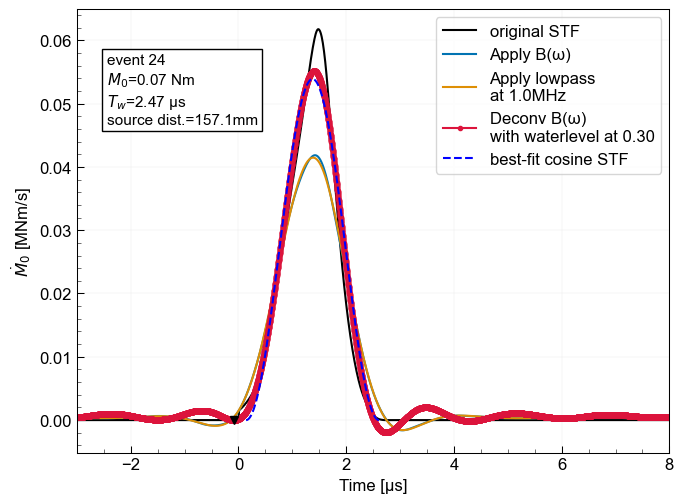

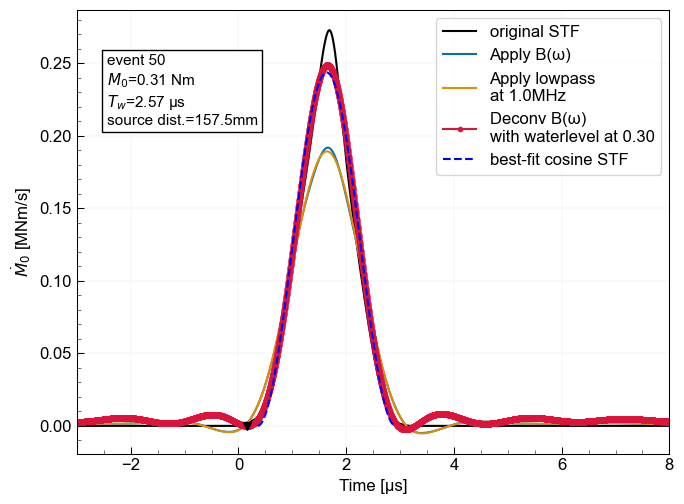

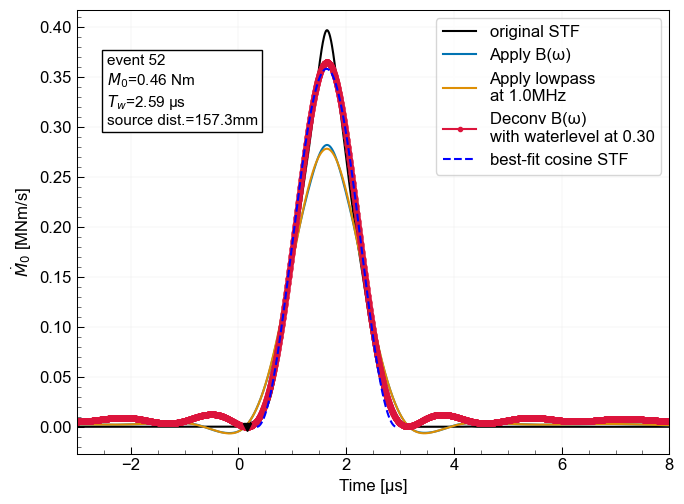

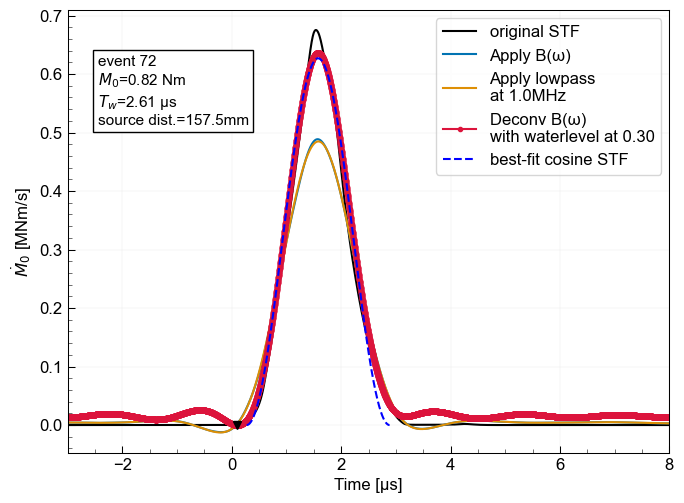

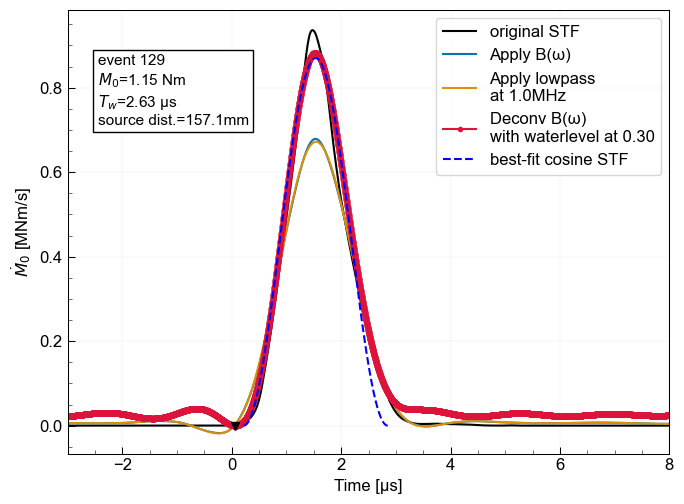

In [22]:
df_dynrup_sourceparam = pd.DataFrame(columns=["event_id", "M0_rec", "M0_bestfit", "Tw_bestfit", "Tshift_bestfit"])

for model_id in model_ids:
# model_id = model_ids[3]
    print(f"prcess {model_id}")
    
    #------------------------#
    # 1. Zeropadding the STF
    #------------------------#
    
    df_modelparam_selected = df_modelparam[df_modelparam.index == model_id]
    
    # if ifParamStudy:
    simulation_name = f"fb03-{expr_id:03d}__{df_modelparam_selected.index[0]:04d}_{casestr}_{delsigma_factorstr[f'{model_id}']:.4f}"
    # else:
        # simulation_name = f"fb03-{expr_id:03d}__{df_modelparam_selected.index[0]:04d}_{casestr}"

    # simulation_name = f"fb03-{expr_id:03d}__{df_modelparam_selected.index[0]:04d}_{casestr}"
    key_M0 = f"M0_rec_{simulation_name}"
    M0_rec = data_all[key_M0]
    
    key_STF = f"STF_rec_{simulation_name}"
    STF_rec = data_all[key_STF]
    tvec_dynrup = df_time.values.squeeze()
    dt_dynrup = tvec_model[1] - tvec_model[0]
    # plt.plot(tvec_model*1e6, STF_rec/1e6, "-", c=lc_dict[datacase], lw=1, zorder=3)

    # upsample the data
    tvec_upsampled = np.arange(tvec_dynrup[0], tvec_dynrup[-1], step=dt_upsampled)
    STF_rec_upsampled = np.interp(tvec_upsampled, tvec_dynrup, STF_rec)
    
    # tpre = -np.arange(dt_dynrup, zerowin_pre, step=dt_dynrup)[::-1]
    # tpost = np.arange(tvec_dynrup[-1]+dt_dynrup, tvec_dynrup[-1]+zerowin_post, step=dt_dynrup)
    tpre = -np.arange(dt_upsampled, zerowin_pre, step=dt_upsampled)[::-1]
    tpost = np.arange(tvec_dynrup[-1]+dt_upsampled, tvec_dynrup[-1]+zerowin_post, step=dt_upsampled)
    tvec_dynrup_padded = np.hstack([tpre, tvec_upsampled, tpost])
    
    post_add = 0
    if np.mod(len(tvec_dynrup_padded), 2) == 1:
        # make tvec length as even
        tvec_dynrup_padded = np.hstack([tvec_dynrup_padded, tvec_dynrup_padded[-1]+dt_upsampled])
        post_add = 1
    
    STF_rec_padded = np.hstack([np.zeros(len(tpre)), STF_rec_upsampled, np.zeros(len(tpost)+post_add)])
    # plt.plot(tvec_dynrup_padded, STF_rec_padded)
    
    #------------------------#
    # 2. Compute attenuation factor
    #------------------------#
    # We use the mean source distance of the four AE sensors to compute the p wave arrival time
    sourcedist_average = df_trimP_coef.loc[f"fb03-{expr_id:03d}__{model_id:04d}"]["rdist"].mean()
    tt_average = sourcedist_average/vp
    print(f"Averaged travel time: {tt_average*1e6:.2f}μs")
    
    Ndata_FFT = len(tvec_dynrup_padded)
    # NFFT = 2**(Ndata_FFT-1).bit_length()
    NFFT = Ndata_FFT # same length of the data for the sake of simplicity
    
    # print(Ndata_FFT, NFFT)
    F_freq = np.fft.rfftfreq(NFFT, d=dt_upsampled)
    Qinv_interp = get_Qinv(F_freq, df_Qinv_quantile.freq.values*1e6, df_Qinv_quantile[f"Qinv_{Qinv_quart}"].values).astype(float)
    
    # plt.loglog(F_freq/1e6, Qinv_interp.real, ".-")
    # plt.xlim([0.1, 2])
    # plt.ylim([0.002, 0.2])
    # plt.xlabel("Frequency [MHz]")
    # plt.ylabel("Attenuation, $Q^{-1}$")
    
    Bomega_interp = np.exp(-np.pi * F_freq * tt_average * Qinv_interp)
    Bomega_wlv = np.maximum(np.abs(Bomega_interp), (k_waterlevel*np.abs(Bomega_interp).max()))
    
    # fig, ax = plt.subplots(1, 1, figsize=(7, 6))
    # ax.loglog(F_freq/1e6, Bomega_interp)
    # ax.loglog(F_freq/1e6, Bomega_wlv)
    # ax.set_xlim([0.06, 2])
    # ax.set_ylim([0.06, 1.2])
    # ax.set_xlabel("Frequency [MHz]")
    # ax.set_ylabel("$B(\omega)$")
    
    #------------------------#
    # 3. Convolve the attenuation factor to mimic the path effect
    #------------------------#
    # compute source spectrum
    F_STF1 = np.fft.rfft(STF_rec_padded, n=NFFT)
    
    #1. convolve the attenuation factor
    STF_Qconvolved = np.fft.irfft(F_STF1 * Bomega_interp).real
    
    #------------------------#
    # 4. Apply the low-pass filter
    #------------------------#
    # b, a = signal.butter(butterworth_order, (freqmin, freqmax), 'bandpass', fs=(1/dt_upsampled), output='ba') # not apply band-pass to mitigate acausal signal
    b, a = signal.butter(butterworth_order, freqmax, 'lowpass', fs=(1/dt_upsampled), output='ba') #
    STF_Qconvolved_filtered = signal.filtfilt(b, a, STF_Qconvolved, method='gust')
    
    
    #------------------------#
    # 5. Deconvolve Bomega with water level
    #------------------------#
    F_STF2 = np.fft.rfft(STF_Qconvolved_filtered, n=NFFT)
    STF_Q_deconvolved = np.fft.irfft(F_STF2/Bomega_wlv).real # divide the spectra by the attenuation factor
    
    #------------------------#
    # 6. Fit the cosine STF to estimate the source parameters
    #------------------------#
    
    # process flow:
    # 1. remove offset at the LBA
    # 2. compute half maximum pulse width to estimate Tw_init
    # 3. search the best-fit source parameters
      
    # pick the LBA as it is
    STF_grad = np.gradient(STF_Q_deconvolved)
            
    # https://stackoverflow.com/a/3843124
    zero_crossings = np.where(np.diff(np.sign(STF_grad)) > 0)[0]
    min_list = np.array(zero_crossings)
    
    LBA_ind = min_list[np.where(int((zerowin_pre+LBA_buffer_winlen)/dt_upsampled) - min_list > 0)[0][-1]] # search the first bump of STF;
    LBA_amp = STF_Q_deconvolved[LBA_ind]
    LBA_t = tvec_dynrup_padded[LBA_ind]
    
    # remove the offset
    STF_Q_deconvolved_offsetremoved = STF_Q_deconvolved-LBA_amp
    
    # compute Tw_init as the HMPW
    pmax = np.max(STF_Q_deconvolved_offsetremoved)
    pmax_ind = np.argmax(STF_Q_deconvolved_offsetremoved)
    
    halfamp = pmax/2
    
    # search the half pulse width
    halfamp_list = np.where(np.diff(np.sign(STF_Q_deconvolved_offsetremoved - halfamp)))[0]
    
    # for tiny events, skip if we cannot find the LHA or RHA due to low S/N
    LHA_ind = halfamp_list[np.where(halfamp_list - pmax_ind < 0)[0][-1]]
    RHA_ind = halfamp_list[np.where(halfamp_list - pmax_ind > 0)[0][0]] # set HMPW just below the half-maximum amplitude
    HMPW = tvec_dynrup_padded[RHA_ind] - tvec_dynrup_padded[LHA_ind]
    Tw_init = 2*HMPW
    M0_init = 0.5*np.max(STF_Q_deconvolved_offsetremoved)*Tw_init
    Tshift_init = 0.0

    # NOTE: The STF of dynamic rupture is narrow. Thus, the HMPW is not enough for the T_init. 
    # To better and stably fit the cosine STF to the model, we increase the T_init.
    # Update: to avoid the jump in the residual during the grid search caused by the dependency of the initial value,
    # we iterate to find the global minimum in the fitting.
    Tw_init_list = Tw_init * np.linspace(1.0, 1.1, 3)
    res_fun_all = []
    # Tw_init *= 1.05

    for Tw_init_test in Tw_init_list:
        x0 = [M0_init, Tw_init_test, Tshift_init]
        # print(x0)
        
        # fit the synthetic STF to the dynamic rupture STF
        res_test = minimize(compute_res, x0, args=(STF_Q_deconvolved_offsetremoved, dt_upsampled, pwin_pre, residu_win, stf_type, False), 
                       method='Nelder-Mead', bounds=bounds, options={"return_all": False, "xatol":xatol, "fatol":fatol, "maxfev":1000})
        res_fun_all.append(res_test.fun)
    
    # use Tw_init with minimum residual 
    Tw_init_best = Tw_init_list[np.argmin(res_fun_all)]
    x0 = [M0_init, Tw_init_best, Tshift_init]
    res = minimize(compute_res, x0, args=(STF_Q_deconvolved_offsetremoved, dt_upsampled, pwin_pre, residu_win, stf_type, False), 
                method='Nelder-Mead', bounds=bounds, options={"return_all": False, "xatol":xatol, "fatol":fatol, "maxfev":1000})
        
    # synthesize the estimated STF
    M0_best, Tw_best, tshift_best = res.x
    # print(Tw_best*1e6)
    tvec_syn = np.linspace(0, Tw_best, int(Tw_best/dt_upsampled))
    STF_syn = stf_cosine(tvec_syn, Tw_best, M0_best)
    
    # Debug plot
    fig, ax = plt.subplots(1, 1, figsize=(7, 5.2))
    ax.plot(tvec_dynrup_padded*1e6, STF_rec_padded/1e6, label="original STF", c="k", zorder=2)
    ax.plot(tvec_dynrup_padded*1e6, STF_Qconvolved/1e6, label="Apply B(ω)", c=lc_debug[0])
    ax.plot(tvec_dynrup_padded*1e6, STF_Qconvolved_filtered/1e6, label=f"Apply lowpass \nat {freqmax/1e6:.1f}MHz", c=lc_debug[1])
    ax.plot(tvec_dynrup_padded*1e6, STF_Q_deconvolved_offsetremoved/1e6, "-", marker=".", 
            label=f"Deconv B(ω) \nwith waterlevel at {k_waterlevel:.2f}", c="crimson")
    # ax.xlim([-4, 6])
    ax.plot(LBA_t*1e6, 0, "kv", ms=6, zorder=5)
    ax.plot((tvec_syn+tshift_best)*1e6, STF_syn/1e6, "--", label=f"best-fit {stf_type} STF", c="b")
    # ax.plot(tvec_dynrup_padded[zero_crossings]*1e6, np.zeros(len(tvec_dynrup_padded[zero_crossings])), "ks", ms=4)
    # ax.axhline(0)
    ax.legend(loc=0)
    
    props = dict(boxstyle='square', facecolor='white', alpha=1.0)
    
    annot_txt = '\n'.join((
        r'event {}'.format(model_id),
        r'$M_0$={:.2f} Nm'.format(M0_best),
        r'$T_w$={:.2f} μs'.format(Tw_best*1e6),
        r'source dist.={:.1f}mm'.format(sourcedist_average*1e3)))
    
    ax.text(0.05, 0.9, annot_txt, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', bbox=props)
    
    # ax.set_xlim(np.array([tvec_dynrup_padded[0], tvec_dynrup_padded[-1]]) * 1e6)
    ax.set_xlim([-3, 8])
    ax.set_xlabel("Time [μs]")
    ylabelstr = r"$\dot{M}_0$"
    ax.set_ylabel("{} [MNm/s]".format(ylabelstr))
    ax.grid(True, c=np.array([230, 230, 230])/255, lw=0.25, zorder=-1, which="major")
    ax.set_axisbelow('True')
    
    fig.tight_layout()
    
    # plt.savefig(figdir + f"/dynrupSTFfit_{gougepatch_id}_event{model_id}.png", dpi=80)
    plt.savefig(figdir + f"/dynrupSTFfit_{gougepatch_id}_event{model_id}{filekey}.pdf")
    # 
    
    # save the best-fit parameters
    data = {"event_id":[model_id],
            "M0_rec":[M0_rec[-1]],
            "M0_bestfit":[M0_best],
            "Tw_bestfit":[Tw_best],
            "Tshift_bestfit":[tshift_best]}
    
    df_param = pd.DataFrame.from_dict(data)
    df_dynrup_sourceparam = pd.concat([df_dynrup_sourceparam if not df_dynrup_sourceparam.empty else None, df_param])
    
    # plt.clf()
    # plt.close()

In [23]:
np.linspace(1.0, 1.1, 3)

array([1.  , 1.05, 1.1 ])

In [24]:
res_fun_all

[10743.055654406118, 10743.055654406087, 10743.055654406078]

In [25]:
np.argmin(res_fun_all)

2

In [26]:
Tw_init

2.62e-06

In [27]:
Tw_best

2.633134847611734e-06

In [28]:
res.fun

10743.055654406078

In [29]:
1428.987180937763

1428.987180937763

In [30]:
tshift_best

2.1729486010068867e-07

In [31]:
df_dynrup_sourceparam

,event_id,M0_rec,M0_bestfit,Tw_bestfit,Tshift_bestfit
0,24,0.064067,0.066481,0.000002,1.413583e-07
0,50,0.303945,0.312725,0.000003,3.530972e-07
0,52,0.452491,0.464220,0.000003,3.408833e-07
0,72,0.803556,0.818885,0.000003,2.724735e-07
0,129,1.142348,1.145508,0.000003,2.172949e-07


In [32]:
# dump the dynamic rupture source parameters to the datasheet
df_dynrup_sourceparam.to_csv(f"../data/dynrup_bestfit_sourceparam_{casestr}{filekey}.csv", index=False, float_format="%12.8g")

## Plot the scaling

In [33]:
df_gougeevent = pd.read_csv(f"../../../../GougeEventCatalog/data/gougeeventcatalog__fb03-{expr_id:03d}__{gougepatch_id}__Q{Qinv_quart}.csv")

In [34]:
Nvalidsensors_thresh = 4
df_gougeevent_selected = df_gougeevent[df_gougeevent["Nvalidsensors"] == Nvalidsensors_thresh]

In [35]:
print(len(df_gougeevent_selected))
df_gougeevent_selected.head()

33


,event_id,location,event_onset_time,stickslip_id,event_label,Q_correction_quart,Nvalidsensors,M0,M0_std,Mw,Tw,Tw_std
0,4,1.75,42.474772,3,A,50,4,0.592607,0.178671,-6.218156,0.000003,1.530315e-07
1,9,1.75,47.662693,5,F,50,4,0.046991,0.007419,-6.951990,0.000002,3.643121e-07
2,18,1.75,56.727044,8,F,50,4,0.755830,0.192507,-6.147717,0.000003,3.100882e-07
3,19,1.75,59.103175,9,F,50,4,0.055755,0.016951,-6.902476,0.000002,2.699155e-07
4,20,1.75,59.103526,9,F,50,4,0.865466,0.210250,-6.108500,0.000003,1.352659e-07


In [36]:
scatter_mc = sns.color_palette("Set1")
scatter_mc

[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (1.0, 0.4980392156862745, 0.0),
 (1.0, 1.0, 0.2),
 (0.6509803921568628, 0.33725490196078434, 0.1568627450980392),
 (0.9686274509803922, 0.5058823529411764, 0.7490196078431373),
 (0.6, 0.6, 0.6)]

In [37]:
df_gougeevent_selected_modelled = df_gougeevent_selected[df_gougeevent_selected["event_id"].isin(model_ids)]

In [38]:
# compute regression
colnames = ["Method", "Intercept", "Slope", "Angle(degrees)", "P-perm(1-tailed)"]
df_res = pd.read_csv("../../../../ComputeScaling/data/07_loglinearfit/lmodel2_out_regression.txt", sep=' ',
                     names=colnames, skipinitialspace=True, skiprows=1, header=None)
df_res = df_res.set_index("Method")
fit_method="MA"

M0_reg = np.logspace(-3, 1, 101)
TR_reg = (10**df_res.loc[fit_method, "Intercept"])*(M0_reg**df_res.loc[fit_method, "Slope"])


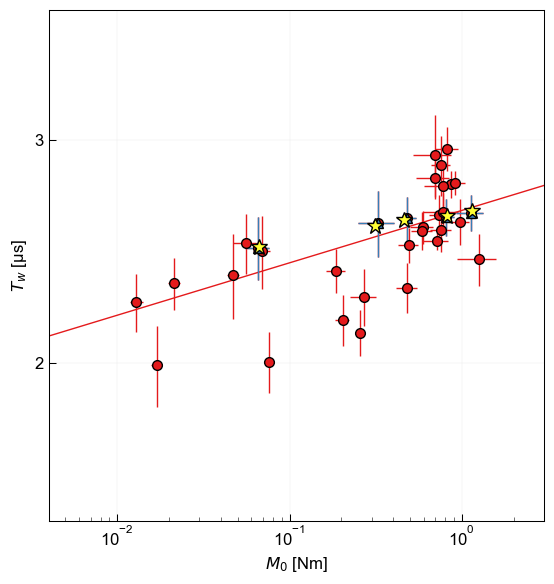

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(5.7, 6))

scatter_kws0 = {"s": 0, "edgecolors": "k", "zorder": 1, "alpha": 0.9}
scatter_kws1 = {"s": 90, "edgecolors": "k", "zorder": 1, "alpha": 0.9}
line_kws = {"color": "crimson", "zorder": -3}

tc = [""]
mctype = ["o", "d", "s", "v"]

labelflag = 0

ifPlotMain = True
ifPlotModeled = True
ifPlotRegression = True

# Compute standard error
standarderror_factor = np.sqrt(Nvalidsensors_thresh)

mainmarkersize = 7

if ifPlotMain:
    ax.errorbar(df_gougeevent_selected["M0"].values, df_gougeevent_selected["Tw"].values*1e6, 
            yerr = df_gougeevent_selected["Tw_std"].values*1e6/standarderror_factor, xerr = df_gougeevent_selected["M0_std"]/standarderror_factor,
            capsize=0, fmt='o', markersize=mainmarkersize, color=scatter_mc[0], lw=1, markeredgecolor = "black", label="Mean of four AE sensors", zorder=3)

if ifPlotModeled:
    ax.errorbar(df_gougeevent_selected_modelled["M0"].values, df_gougeevent_selected_modelled["Tw"].values*1e6, 
        yerr = df_gougeevent_selected_modelled["Tw_std"].values*1e6/standarderror_factor, xerr = df_gougeevent_selected_modelled["M0_std"]/standarderror_factor,
        capsize=0, fmt='^', markersize=mainmarkersize, color=scatter_mc[1], lw=1, markeredgecolor = "black", label="Mean of four AE sensors", zorder=3)

# plot the best-fit regression
if ifPlotRegression:
    ax.plot(M0_reg, TR_reg, c=scatter_mc[0], lw=1.0, zorder = 2)


# Plot scaling of dynamic rupture model
ax.plot(df_dynrup_sourceparam["M0_bestfit"].values, df_dynrup_sourceparam["Tw_bestfit"].values*1e6, "*", ms=12, mfc=scatter_mc[5], mec="k",
        label="Dynamic rupture model", zorder=4)
           
        # yerr = df_gougeevent_selected["Tw_std"].values*1e6/standarderror_factor, xerr = df_gougeevent_selected["M0_std"]/standarderror_factor,
        # capsize=0, fmt='o', markersize=mainmarkersize, color=scatter_mc[0], lw=1, markeredgecolor = "black", label="Mean of four AE sensors", zorder=3)



xlimit_scaling = [0.004, 3] #10] # check 1/3
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(xlimit_scaling)
ax.set_ylim([1.5, 3.8]) #10]) # update 2025/1/23 # check 1/3

# ax.set_yticks([1, 2, 3, 4])
# ax.set_yticklabels([1, 2, 3, 4])
ax.set_yticks([2, 3, ]) # update 2025/1/23
ax.set_yticklabels([2, 3, ]) # update 2025/1/23

ax.set_xlabel("$M_0$ [Nm]")
ax.set_ylabel("$T_w$ [μs]")

ax.grid(True, c=np.array([230, 230, 230])/255, lw=0.25, zorder=-1)
ax.set_axisbelow('True')

plt.tight_layout()

plt.savefig(figdir+f"/preliminary_dynrupscaling_{casestr}_{nb_x_elements}{filekey}.png",  dpi=200)
plt.savefig(figdir+f"/preliminary_dynrupscaling_{casestr}_{nb_x_elements}{filekey}.pdf")


# Dump the data into HDF5

We save the data on the time history of $M_0$ and STFs into the HDF5 file.

In [40]:
if ifSaveHDF: # save the data only for the master case study
    
    fo = h5py.File(datadir+f"/DynrupModelData_{casestr}_{nb_x_elements}{filekey}.hdf5", 'w')
    
    fo.create_group("param")
    fo.create_dataset(f"param/tvec_dynrup", data=df_time[1].values)
    fo[f"param"].attrs["E"] = E
    fo[f"param"].attrs["nu"] = nu
    fo[f"param"].attrs["mu"] = mu
    fo[f"param"].attrs["a_patch"] = a_patch
    fo[f"param"].attrs["rupturetype"] = rupturetype
    fo[f"param"].attrs["pdcscaling"] = pdcscaling
    fo[f"param"].attrs["bgbeta"] = bgbeta
    fo[f"param"].attrs["nb_x_elements"] = nb_x_elements
    fo[f"param"].attrs["nb_z_elements"] = nb_z_elements


In [41]:
if ifSaveHDF:
    for model_id in model_ids:
    
        fo.create_group(f"dynrup_{model_id:04d}")
    
        df_modelparam_selected = df_modelparam[df_modelparam.index == model_id]
        simulation_name = f"fb03-{expr_id:03d}__{df_modelparam_selected.index[0]:04d}_{casestr}_{delsigma_factorstr[f'{model_id}']:.4f}"
        print(f"{simulation_name}")
        key_t = f"t_{simulation_name}"
        key_M0 = f"M0_rec_{simulation_name}"
        key_STF = f"STF_rec_{simulation_name}"
        key_STF_patch = f"STF_patch_{simulation_name}"
    
        fo.create_dataset(f"dynrup_{model_id:04d}/M0_rec", data=data_all[key_M0])
        fo.create_dataset(f"dynrup_{model_id:04d}/STF_rec", data=data_all[key_STF])
        # fo.create_dataset(f"dynrup_{model_id:04d}/STF_patch", data=data_all[key_STF_patch])
    
    fo.close()

fb03-087__0024_a=4.00_ruptype=pulse_pdcscaling=0.600_sn=6.0MPa_hatfr=0.3_bgbeta=0.35_0.6950
fb03-087__0050_a=4.00_ruptype=pulse_pdcscaling=0.600_sn=6.0MPa_hatfr=0.3_bgbeta=0.35_0.5000
fb03-087__0052_a=4.00_ruptype=pulse_pdcscaling=0.600_sn=6.0MPa_hatfr=0.3_bgbeta=0.35_0.4600
fb03-087__0072_a=4.00_ruptype=pulse_pdcscaling=0.600_sn=6.0MPa_hatfr=0.3_bgbeta=0.35_0.4300
fb03-087__0129_a=4.00_ruptype=pulse_pdcscaling=0.600_sn=6.0MPa_hatfr=0.3_bgbeta=0.35_0.4100
